In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
path_to_dataset = "healthcare-dataset-stroke-data.csv"
MODEL_TYPE = "xgb" # "logistic" 
df = pd.read_csv(path_to_dataset)
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
df.drop('id', axis=1, inplace=True)
df = df[df['gender'] != 'Other'] 
# df.drop('hypertension', axis=1, inplace=True)
# df.drop('heart_disease', axis=1, inplace=True)

In [4]:
if MODEL_TYPE == "xgb":
    cat_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
    for col in cat_cols: df[col] = df[col].astype('category')

In [5]:
if MODEL_TYPE == "logistic" or MODEL_TYPE == "xgb":
    from sklearn.preprocessing import LabelEncoder
    df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})
    df['ever_married'] = df['ever_married'].map({'Yes': 1, 'No': 0})
    mapping = {'never smoked': 0, 'smokes': 1, 'formerly smoked': 2, 'Unknown': 3}
    df['smoking_status'] = df['smoking_status'].map(mapping)
    label_encoder_work_type = LabelEncoder()
    df['work_type'] = label_encoder_work_type.fit_transform(df['work_type'])
    label_encoder_residence_type = LabelEncoder()
    df['Residence_type'] = label_encoder_residence_type.fit_transform(df['Residence_type'])
    mean_bmi = df['bmi'].mean()
    df['bmi'].fillna(mean_bmi, inplace=True)

In [6]:
X = df.drop('stroke', axis=1)
y = df['stroke']

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [8]:
if MODEL_TYPE == "xgb":
    import xgboost as xgb
    model = xgb.XGBClassifier(enable_categorical=True)
    model.fit(X_train, y_train)
elif MODEL_TYPE == "logistic":
    from sklearn.linear_model import LogisticRegression  
    model = LogisticRegression()
    model.fit(X_train, y_train)

In [9]:
y_pred = model.predict(X_test)

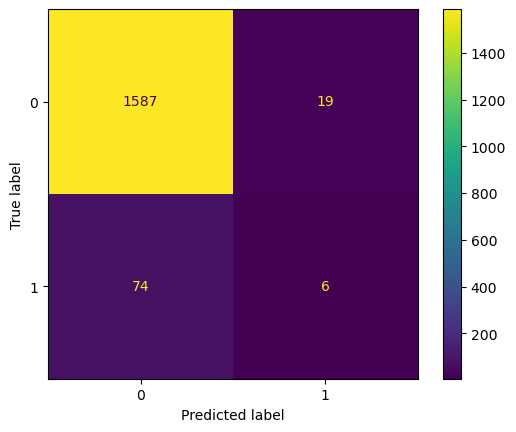

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

In [11]:
from sklearn.metrics import classification_report
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1661
           1       0.07      0.24      0.11        25

    accuracy                           0.94      1686
   macro avg       0.53      0.60      0.54      1686
weighted avg       0.97      0.94      0.96      1686



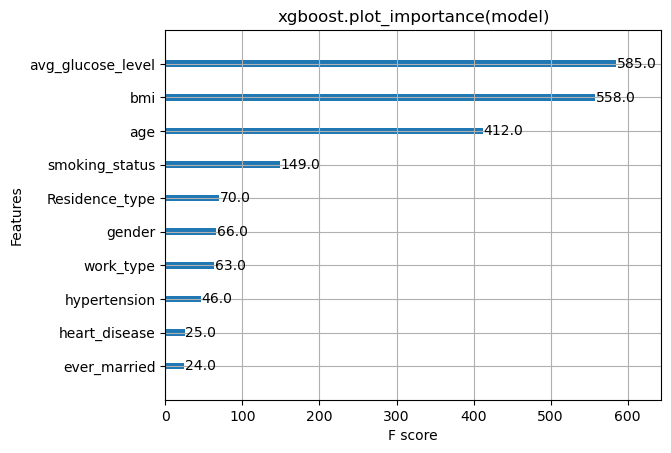

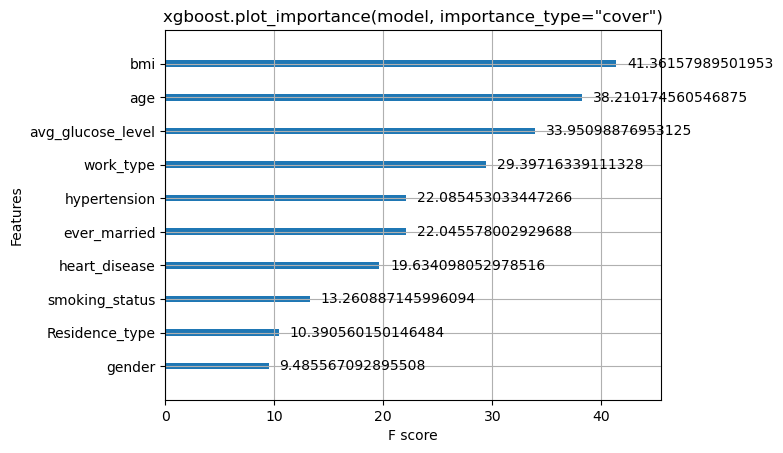

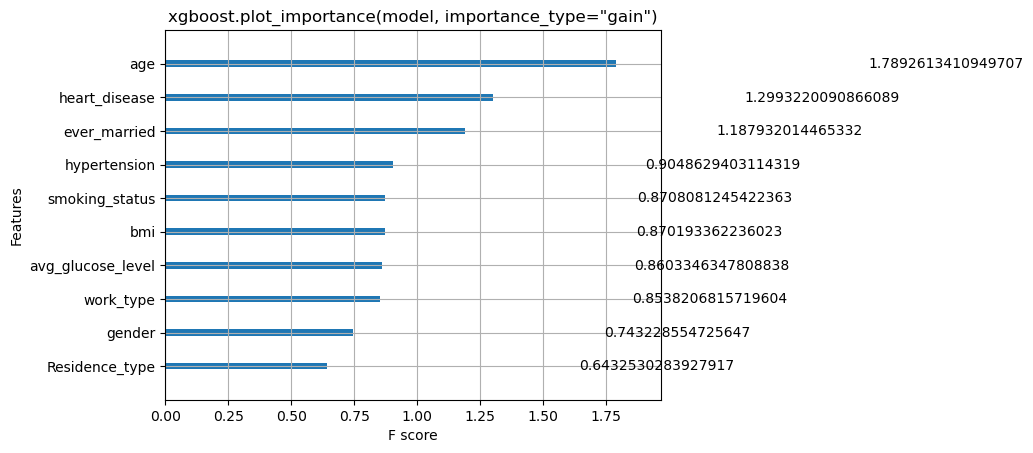

In [12]:
if MODEL_TYPE == "xgb":
    # 
    # * 'weight': the number of times a feature is used to split the data across all trees.
    # * 'gain': the average gain across all splits the feature is used in.
    # * 'cover': the average coverage across all splits the feature is used in.
    # * 'total_gain': the total gain across all splits the feature is used in.
    # * 'total_cover': the total coverage across all splits the feature is used in.
    # 
    xgb.plot_importance(model)
    plt.title("xgboost.plot_importance(model)")
    plt.show()
    # 
    # 
    xgb.plot_importance(model, importance_type="cover")
    plt.title('xgboost.plot_importance(model, importance_type="cover")')
    plt.show()
    # 
    xgb.plot_importance(model, importance_type="gain")
    plt.title('xgboost.plot_importance(model, importance_type="gain")')
    plt.show()


In [13]:
import shap
if MODEL_TYPE == "xgb":
    try:
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X)
    except Exception as e:
        print("ERROR!")
        print(e)
        explainer = shap.Explainer(model.predict, X)
        shap_values = explainer(X)
elif MODEL_TYPE == "logistic":
    explainer = shap.Explainer(model.predict, X)
    shap_values = explainer(X)

[09:08:09] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


ERROR!
[09:08:09] /Users/runner/work/xgboost/xgboost/src/tree/tree_model.cc:899: Check failed: !HasCategoricalSplit(): Please use JSON/UBJSON for saving models with categorical splits.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000175c54994 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000175e7fb90 xgboost::RegTree::Save(dmlc::Stream*) const + 1252
  [bt] (2) 3   libxgboost.dylib                    0x0000000175d954fc xgboost::gbm::GBTreeModel::Save(dmlc::Stream*) const + 296
  [bt] (3) 4   libxgboost.dylib                    0x0000000175d9fbbc xgboost::LearnerIO::SaveModel(dmlc::Stream*) const + 1828
  [bt] (4) 5   libxgboost.dylib                    0x0000000175c7b1e0 XGBoosterSaveModelToBuffer + 784
  [bt] (5) 6   libffi.8.dylib                      0x0000000104ff004c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x0000000104fed834 ffi_call_int + 1404
  [bt] (7) 8   _ctypes.c

ExactExplainer explainer: 5110it [04:19, 19.06it/s]                          


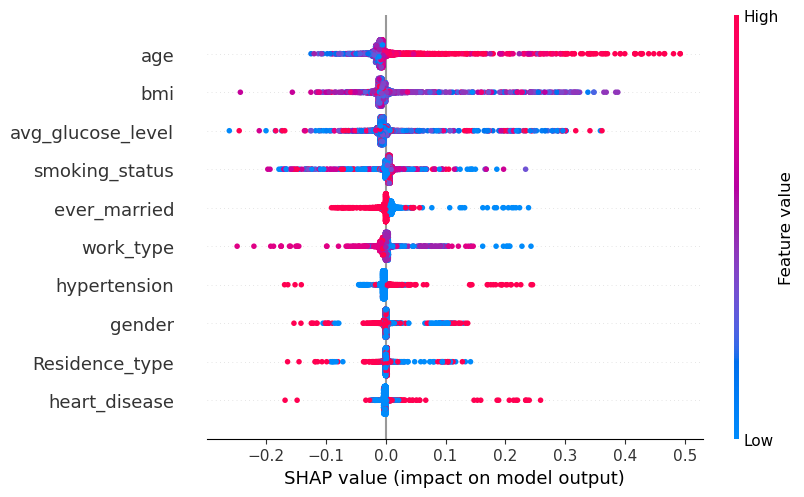

In [14]:
shap.plots.beeswarm(shap_values)

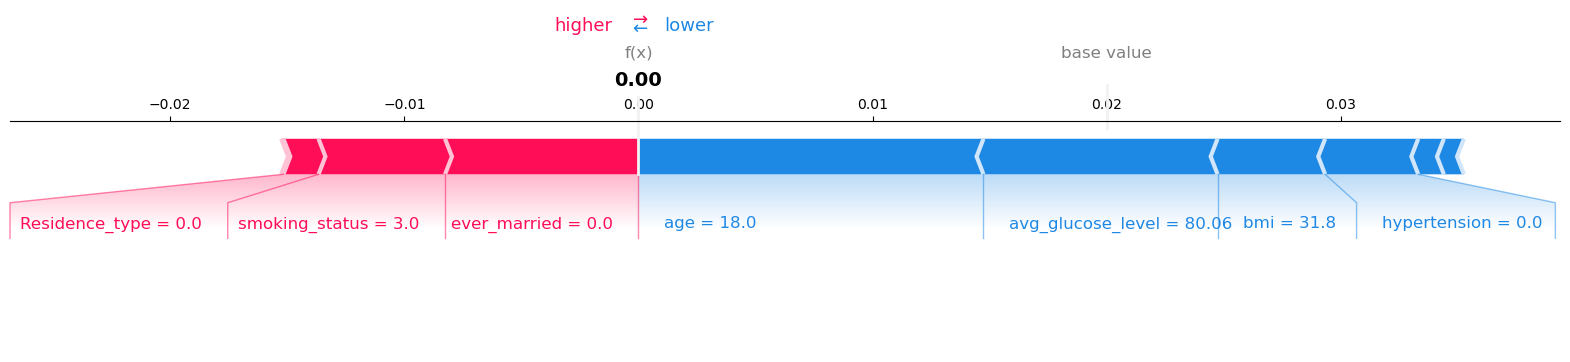

In [15]:
idx = 79
pos = y_train.index.get_loc(idx)
shap.plots.force(shap_values[pos], matplotlib=True)

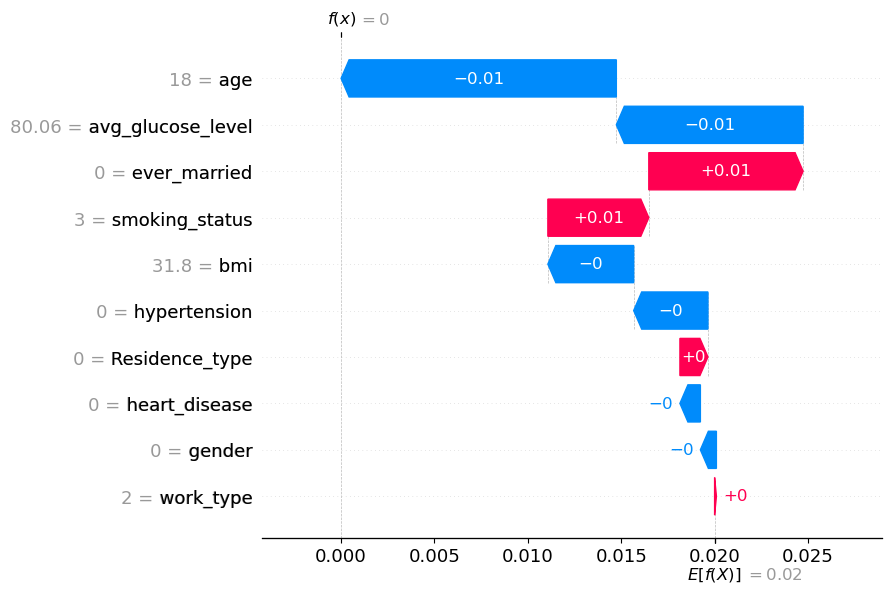

In [16]:
shap.plots.waterfall(shap_values[pos], max_display=14)

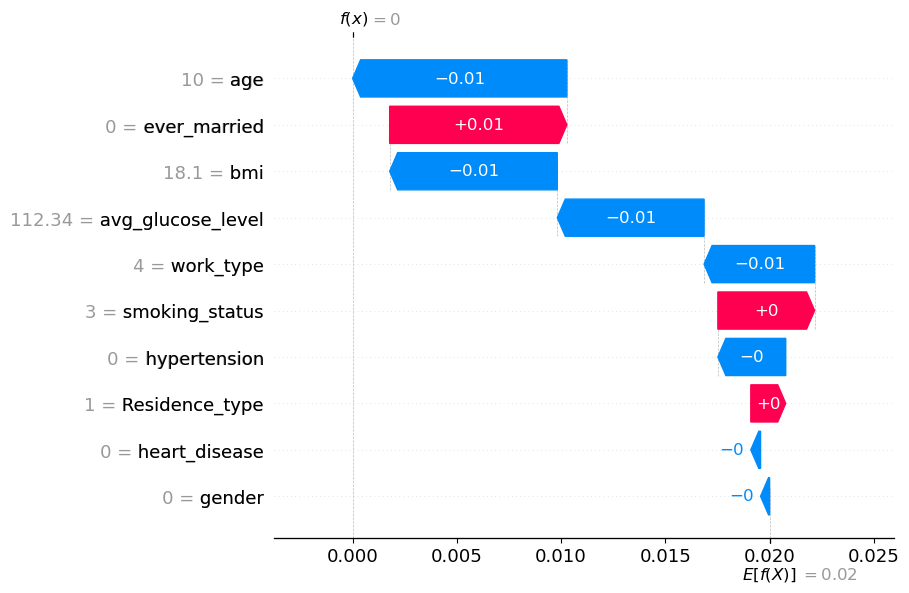

In [17]:
idx = 4211
pos = y_train.index.get_loc(idx)
shap.plots.waterfall(shap_values[pos], max_display=10)